In [ ]:
# 라이브러리 로드
# requests는 작은 웹브라우저로 웹사이트 내용을 가져온다.
import requests
# BeautifulSoup 을 통해 읽어 온 웹페이지를 파싱한다.
from bs4 import BeautifulSoup as bs
# 크롤링 후 결과를 데이터프레임 형태로 보기 위해 불러온다.
import pandas as pd
# 각 단어의 빈도수
from collections import Counter

from tqdm import trange

In [ ]:
# 크롤링 할 사이트
base_url = "https://finance.naver.com/research/company_list.nhn"
response = requests.get( base_url )
response

In [ ]:
soup = bs(response.text, 'html.parser')

In [ ]:
#contentarea_left > div.box_type_m > table.type_1 > tbody > tr:nth-child(3)

In [ ]:
   
test_url = "https://finance.naver.com/research/company_read.nhn?nid=56296&page=1"
response = requests.get( test_url )    
test_soup = bs(response.text, 'html.parser')

content = test_soup.select("#contentarea_left > div.box_type_m.box_type_m3 > table > div")
# 가장 마지막 것
#content[-1]
content

In [ ]:
prefix_addr = "https://finance.naver.com/research/"

for href in soup.find("div", class_="box_type_m").find_all("a"):
    if "company_read" in href.get("href"):
        print(prefix_addr + href.get("href"))

In [ ]:
list_jongmok_link = []
list_temp = []
for href in soup.find("div", class_="box_type_m").find_all("a"):
    if href.get("title") is not None:
        list_temp.append(href.get("title"))
    if "company_read" in href.get("href"): 
        list_temp.append(prefix_addr + href.get("href"))
        list_jongmok_link.append(list_temp)
        list_temp = []
list_jongmok_link

In [ ]:
df_jongmok = pd.DataFrame(list_jongmok_link, columns=["NAME", "LINK"])

df_jongmok

In [ ]:
df_jongmok.to_csv("report.csv", index=False, encoding="utf-8-sig")

In [ ]:
# 크롤링 할 사이트
sub_url = "https://finance.naver.com/research/company_read.nhn?nid=56299&page=1"
response = requests.get( sub_url )
response

In [ ]:
sub_soup = bs(response.text, 'html.parser')

In [ ]:
# #contentarea_left > div.box_type_m.box_type_m3
for in_text in sub_soup.find("div", class_="box_type_m").find_all('p'):
    print(str(in_text))

In [ ]:
###############################################################################################################
# 리서치 보고서
###############################################################################################################
list_replace_char= [
    "<p>", "<strong>", "</p>", "</strong>", "<br/>", "\n", "\t"
]

import telegram

def send_message(msg):
    chat_token = "1740739677:AAFjOUObIBcjKs3nKAuHn4m349jbZvl6N6o"
    chat = telegram.Bot(token = chat_token)
    updates = chat.getUpdates()
    print(updates)
    for u in updates:
        chat_id = u.message['chat']['id']

    bot = telegram.Bot(token = chat_token)
    text = msg
    bot.sendMessage(chat_id = chat_id, text=text)

def count_word_freq(in_param):
    list_word_freq = []
    wordDict = Counter()

    in_param = in_param.replace(":","").replace("및","").replace("으로","").replace("하며","").replace("했다","")
    for word in in_param.split(): #한 문장에 들어있는 한 단어씩
        wordDict[word] += 1 #Counter에 count를 1씩 증가시킨다.

    for word, freq in wordDict.most_common(1000):
        list_word_freq.append(word + ":" + str(freq))
    
    return list_word_freq

def calc_posi_nega_word(df_jongmok):
    # 구분 키워드
    posi_word = ["상향","추천","안정","투자","매수","상승","개선","최대 실적","성장+","가파르게 상승","가파르게상승","개선","혁신","1위","1 위","선도","긍정적","실적 회복","최고치",
                 "실적호조","호실적"]
    nega_word = ["하향","매도","하락","악재","하락","부진","하회","실적 악화","하회","성장-","가파르게 하락","가파르게하락","진부","부정적","최저치","급락","매출 감소","매출감소",
                 "이익 감소","이익감소","성장 둔화","성장둔화","매출부진","부진"]
    
    def get_word_count(list_word_freq, check_word):
        for word in list_word_freq:
            if check_word in word:
                return int(word.split(":")[1])
            
        return 0

    list_columns = [
        "JONGMOK_CODE", "JONGMOK_NAME", "POSITIVE_CNT", "NEGATIVE_CNT", "RESULT_CNT"
    ]

    list_report = []
    for _, row in df_jongmok.iterrows():
        list_word_freq = count_word_freq(row["REPORT"])
                
        posi_cnt = 0
        nega_cnt = 0
        list_temp = []
        
        for word in posi_word:
            posi_cnt += get_word_count(list_word_freq, word)

        for word in nega_word:
            nega_cnt += get_word_count(list_word_freq, word)
                
        if (posi_cnt > 0 or nega_cnt > 0):
            list_temp.append(row["JONGMOK_CODE"])
            list_temp.append(row["JONGMOK_NAME"])
            list_temp.append(posi_cnt)
            list_temp.append(nega_cnt)
            list_temp.append(posi_cnt - nega_cnt)
            list_report.append(list_temp)

    df_result = pd.DataFrame(list_report, columns=list_columns)
    df_result = df_result.sort_values(by=["JONGMOK_CODE"], axis=0)
    return df_result

def get_text_detail(link_url):
    response = requests.get( link_url )
    link_soup = bs(response.text, 'html.parser')
    result_text = ""
    for link_text in link_soup.find("div", class_="box_type_m").find_all('p'):
        get_text = str(link_text)
        if '<b class="bar">|</b>조회' not in get_text:
            result_text += get_text
    
    for char in list_replace_char:
        result_text = result_text.replace(char, "")
        
    return result_text.strip()

# 앞에 붙이는 고정 주소
prefix_addr = "https://finance.naver.com/research/"
# 크롤링 할 사이트
base_url = "https://finance.naver.com/research/company_list.nhn"
# 종목, 사이트 저장할 리스트
list_jongmok_link = []
list_temp = []
# 페이지 단위로 추출 저장    
for page in range(20):
    
    if page > 0:
        main_url = base_url + "?&page=" + str(page)
    else:
        main_url = base_url
        
    response = requests.get( main_url )
    soup = bs(response.text, 'html.parser')

    for href in soup.find("div", class_="box_type_m").find_all("a"):
        if "code" in href.get("href"):
            list_temp.append(href.get("href").split("code=")[1])
        if href.get("title") is not None:
            list_temp.append(href.get("title"))
        if "company_read" in href.get("href"): 
            list_temp.append(prefix_addr + href.get("href"))
            list_jongmok_link.append(list_temp)
            list_temp = []
    
df_jongmok = pd.DataFrame(list_jongmok_link, columns=["JONGMOK_CODE", "JONGMOK_NAME", "LINK"])

list_df_value = []
for link in list_jongmok_link:
    report_text = get_text_detail(link[2])
    list_df_value.append(report_text)

df_jongmok["REPORT"] = list_df_value
df_jongmok = df_jongmok.drop_duplicates()
df_jongmok.to_csv("report.csv", index=False, encoding="utf-8-sig")
df_result = calc_posi_nega_word(df_jongmok)

df_grouped = df_result.groupby(['JONGMOK_NAME'])['RESULT_CNT'].sum().reset_index()
#df_grouped.loc[df_grouped.RESULT_CNT > 0].to_csv("report.csv", index=False, encoding="utf-8-sig")


In [ ]:
df_msg_posi = df_grouped.sort_values(by=["RESULT_CNT"], axis=0, ascending=False).head(15)
df_msg_nega = df_grouped.sort_values(by=["RESULT_CNT"], axis=0).head(15)

def call_send_msg(df_msg, div):
    msg_string = "# " + div + "\n"
    for _, row in df_msg.iterrows():
        msg_string += row["JONGMOK_NAME"] + " [" + str(row["RESULT_CNT"]) + "]\n" 
    send_message(msg_string)
    
call_send_msg(df_msg_posi, "긍정")    
call_send_msg(df_msg_nega, "부정")    

In [ ]:
###############################################################################################################
# 긍정, 부정 종목
###############################################################################################################

# 구분 키워드
posi_word = ["상향","추천","안정","투자","매수","상승","개선","최대 실적"]
nega_word = ["하향","매도","하락","악재","하락","부진","하회","실적 악화"]

list_columns = [
    "JONGMOK_CODE", "JONGMOK_NAME", "POSITIVE_CNT", "NEGATIVE_CNT", "RESULT_CNT"
]

list_report = []
for _, row in df_jongmok.iterrows():
    posi_cnt = 0
    nega_cnt = 0
    list_temp = []
    for word in posi_word:
        if word in row["REPORT"]:
            posi_cnt += 1
    for word in nega_word:
        if word in row["REPORT"]:
            nega_cnt += 1
    if (posi_cnt > 0 or nega_cnt > 0):
        list_temp.append(row["JONGMOK_CODE"])
        list_temp.append(row["JONGMOK_NAME"])
        list_temp.append(posi_cnt)
        list_temp.append(nega_cnt)
        list_temp.append(posi_cnt - nega_cnt)
        list_report.append(list_temp)
        
df_result = pd.DataFrame(list_report, columns=list_columns)
df_result = df_result.sort_values(by=["JONGMOK_CODE"], axis=0)
df_result

In [ ]:
df_grouped = df_result.groupby(['JONGMOK_NAME'])['RESULT_CNT'].sum().reset_index()
#df_grouped.loc[df_grouped.RESULT_CNT > 0].to_csv("report.csv", index=False, encoding="utf-8-sig")
df_grouped.sort_values(by=["RESULT_CNT"], axis=0, ascending=False).head(10)

In [ ]:
###############################################################################################################
# 긍정 종목
###############################################################################################################
list_columns = [
    "JONGMOK_CODE", "JONGMOK_NAME", "CNT"
]

list_positive = []
for _, row in df_jongmok.iterrows():
    pos_cnt = 0
    list_temp = []
    for word in pos_word:
        if word in row["REPORT"]:
            pos_cnt += 1
    if pos_cnt > 2:
        list_temp.append(row["JONGMOK_CODE"])
        list_temp.append(row["JONGMOK_NAME"])
        list_temp.append(pos_cnt)
        list_positive.append(list_temp)
        
df_positive = pd.DataFrame(list_positive, columns=list_columns)
df_positive = df_positive.sort_values(by=["JONGMOK_CODE"], axis=0)

idx = 0
pos_cnt = 0
list_result = []
for _, row in df_positive.iterrows():
    list_temp = []
    if idx > 0:
        if pre_code == row["JONGMOK_CODE"]:
            pos_cnt = row["CNT"]
        else:
            list_temp.append(pre_code)
            list_temp.append(pre_name)
            list_temp.append(pre_cnt)
            list_result.append(list_temp)
            pos_cnt = 0
        
    pre_code = row["JONGMOK_CODE"]
    pre_name = row["JONGMOK_NAME"]
    pre_cnt = pos_cnt + row["CNT"]
    
    idx += 1
    
list_temp = []    
list_temp.append(pre_code)
list_temp.append(pre_name)
list_temp.append(pre_cnt)    
list_result.append(list_temp)
    
list_result

df_result = pd.DataFrame(list_result, columns=list_columns)
df_result = df_result.sort_values(by=["CNT", "JONGMOK_CODE"], axis=0)
df_result

In [ ]:
###############################################################################################################
# 부정 종목
###############################################################################################################
list_columns = [
    "JONGMOK_CODE", "JONGMOK_NAME", "CNT"
]

list_negative = []
for _, row in df_jongmok.iterrows():
    nega_cnt = 0
    list_temp = []
    for word in nega_word:
        if word in row["REPORT"]:
            nega_cnt += 1
            nega_str += word + ", "
    if nega_cnt > 0:
        list_temp.append(row["JONGMOK_CODE"])
        list_temp.append(row["JONGMOK_NAME"])
        list_temp.append(nega_cnt * -1)
        list_negative.append(list_temp)

df_negative = pd.DataFrame(list_negative, columns=list_columns)        
df_negative        

idx = 0
pos_cnt = 0
list_result = []
for _, row in df_negative.iterrows():
    list_temp = []
    if idx > 0:
        if pre_code == row["JONGMOK_CODE"]:
            pos_cnt = row["CNT"]
        else:
            list_temp.append(pre_code)
            list_temp.append(pre_name)
            list_temp.append(pre_cnt)
            list_result.append(list_temp)
            pos_cnt = 0
        
    pre_code = row["JONGMOK_CODE"]
    pre_name = row["JONGMOK_NAME"]
    pre_cnt = pos_cnt + row["CNT"]
    
    idx += 1
    
list_temp = []    
list_temp.append(pre_code)
list_temp.append(pre_name)
list_temp.append(pre_cnt)    
list_result.append(list_temp)
    
list_result

df_result = pd.DataFrame(list_result, columns=list_columns)
df_result = df_result.sort_values(by=["CNT", "JONGMOK_CODE"], axis=0)
df_result

In [ ]:
###############################################################################################################
# 긍정, 부정 종목 합치기
###############################################################################################################
def posi_nega_info(df_positive, df_negative):
    list_columns = [
        "JONGMOK_CODE", "JONGMOK_NAME", "CNT"
    ]
    
    idx = 0
    pos_cnt = 0
    list_result = []
    for _, row in df_positive.iterrows():
        list_temp = []
        if idx > 0:
            if pre_code == row["JONGMOK_CODE"]:
                pos_cnt = row["CNT"]
            else:
                list_temp.append(pre_code)
                list_temp.append(pre_name)
                list_temp.append(pre_cnt)
                list_result.append(list_temp)
                pos_cnt = 0

        pre_code = row["JONGMOK_CODE"]
        pre_name = row["JONGMOK_NAME"]
        pre_cnt = pos_cnt + row["CNT"]

        idx += 1

    list_temp = []    
    list_temp.append(pre_code)
    list_temp.append(pre_name)
    list_temp.append(pre_cnt)    
    list_result.append(list_temp)

    list_result

    df_result = pd.DataFrame(list_result, columns=list_columns)
    df_result = df_result.sort_values(by=["CNT", "JONGMOK_CODE"], axis=0)
    return df_result

In [ ]:
########################################################################################################
# 코스피200 종목 가져오기
########################################################################################################
# 크롤링 할 사이트
base_url = "https://finance.naver.com/sise/entryJongmok.nhn"
# 종목, 사이트 저장할 리스트
list_jongmok_link = []
# 제거할 tag
list_replace_char= [
    "<p>", "<strong>", "</p>", "</strong>", "<br/>", "\n", "\t", "<tr>", "</tr>", "<td>", "</td>", "</span>"
]

def remove_special_char(in_href):
    result_text = in_href
    for char in list_replace_char:
        result_text = result_text.replace(char, "")
    return result_text

def extract_jongmok_info(in_param):
    jongmok_code = in_param.split(' target="_parent">')[0].split("code=")[1].replace('"', '')
    jongmok_name = in_param.split(' target="_parent">')[1].split("</a")[0]
    return jongmok_code, jongmok_name

def extract_price_info(in_param):
    price_now = in_param.split("<td class=")[0]
    price_comp = in_param.split("<span class=")[1].split(">")[1].split("<td class=")[0]
    rate_comp = in_param.split('%<td class="number">')[0].split('><span class="tah')[2].split(">")[1]
    deal_amount = in_param.split('%<td class="number">')[1].split("<")[0]
    return price_now, price_comp, rate_comp, deal_amount

# 페이지 단위로 추출 저장    
for page in range(21):
    
    if page > 0:
        main_url = base_url + "?&page=" + str(page + 1)
    else:
        main_url = base_url
    
    response = requests.get( main_url, headers={"User-agent": "Mozilla/5.0"} )
    soup = bs(response.text, 'html.parser')

    for href in soup.find("div", class_="box_type_m").find_all("tr"):
        list_temp = []
        str_href = str(href)
        if '<td class="ctg">' in str_href:        
            removed_str = remove_special_char(str_href)        
            jongmok_code, jongmok_name = extract_jongmok_info(removed_str)
            price_now, price_comp, rate_comp, deal_amount = extract_price_info(removed_str.split('</a><td class="number_2">')[1])
            if len(jongmok_code) > 0:
                list_temp.append(jongmok_code)
                list_temp.append(jongmok_name)
                list_temp.append(price_now)
                list_temp.append(price_comp)
                list_temp.append(rate_comp)
                list_temp.append(deal_amount)
                list_jongmok_link.append(list_temp)

df_kospi200 = pd.DataFrame(list_jongmok_link, columns=["JONGMOK_CODE","JONGMOK_NAME", "END_PRICE","COMP_PRICE","COMP_RATE","DEAL_AMOUNT"])
df_kospi200

In [ ]:
###############################################################################################################
# 외국인 매매동향. KOSPI200에서 호출
###############################################################################################################
def forgn_poss_info(jongmok_code, jongmok_name):
    #jongmok_code = "005930"
    #jongmok_name = "삼성전자"
    list_columns = [
        "JONGMOK_CODE","JONGMOK_NAME","END_DT","END_PRICE","COMP_PRICE","COMP_RATE","COMP_DEAL","COMPANY_DEAL","FORGN_DEAL","FORGN_POSS","FORGN_RATE"
    ]
    main_url = "https://finance.naver.com/item/frgn.nhn?code=" + jongmok_code
    response = requests.get( main_url, headers={"User-agent": "Mozilla/5.0"} )
    soup = bs(response.text, 'html.parser')

    def get_date(in_param):
        deal_date = in_param.split("</span>")[0]
        deal_date = deal_date[len(deal_date) - 10:].replace(".", "")
        #print(deal_date)
        return deal_date

    def end_price(in_param):
        end_price = in_param.split("</span>")[0].split("<span class=")[1].split(">")[1]
        #print(end_price)
        return end_price

    def extract_others(in_param):
        result_value = in_param.split("<span class=")[1].split(">")[1].split("<")[0].strip()
        #print(result_value)    
        return result_value
    
    def calc_mean_poss(df):
        end_price = 0
        company_deal = 0
        forgn_deal = 0
        forgn_rate = 0
        for _, row in df.iterrows():
            # 20일 이동평균 계산
            end_price += int(row["END_PRICE"].replace(",", "").strip())
            # 기관 매매량
            company_deal += int(row["COMPANY_DEAL"].replace(",", "").strip())
            # 외국인 매매량
            forgn_deal += int(row["FORGN_DEAL"].replace(",", "").strip())
            # 외국인 보유비율
            forgn_rate += float(row["FORGN_RATE"].replace(",", "").strip())
        avg_price = int(end_price / 20)
        forgn_rate = forgn_rate / 20
        
        print(avg_price, company_deal, forgn_deal, forgn_rate)

    list_foreign_info = []
    list_daily = []
    start_tf = False
    idx = 0

    for href in soup.find("div", class_="content_wrap").find_all("td"):
        str_href = str(href)    
        if start_tf == False:
            if '<td class="tc"' in str_href:
                list_foreign_info.append(list_daily)
                list_daily.append(get_date(str_href))
                start_tf = True
                idx += 1
            continue
        # 종료
        if '<td class="on">' in str_href:
            break
        # 일자를 만나는 경우
        if '<td class="tc"' in str_href:
            idx = 0        

        if idx == 0:
            list_foreign_info.append(list_daily)
            list_daily = []            
            list_daily.append(get_date(str_href))        
        #print(idx, str_href)

        elif idx == 1:
            list_daily.append(end_price(str_href))
        else:
            try:
                extract_value = extract_others(str_href)
                extract_value = extract_value.replace("%", "").replace("+", "")
                list_daily.append(extract_value)
            except:
                pass
        idx += 1

    list_foreign_info.append(list_daily)        
    del list_foreign_info[0]

    df_foreign = pd.DataFrame(list_foreign_info, columns=[list_columns[2:]])
    df_foreign["JONGMOK_CODE"] = jongmok_code
    df_foreign["JONGMOK_NAME"] = jongmok_name
    df_foreign = df_foreign[list_columns]
    
    calc_mean_poss(df_foreign)
    
    #return df_foreign

In [ ]:
forgn_poss_info("005930", "삼성전자")

In [ ]:
########################################################################################################
# 네이버 증권 속보
########################################################################################################
# requests는 작은 웹브라우저로 웹사이트 내용을 가져온다.
import requests
# BeautifulSoup 을 통해 읽어 온 웹페이지를 파싱한다.
from bs4 import BeautifulSoup as bs
# 크롤링 후 결과를 데이터프레임 형태로 보기 위해 불러온다.
import pandas as pd
import datetime

base_url = "https://finance.naver.com/news/news_list.nhn?mode=LSS3D&section_id=101&section_id2=258&section_id3=402"


def extract_value(in_param, idx):
    nam = idx % 7
    # date
    try:
        if nam == 1:
            result_value = in_param.split('<span class="tah p10 gray03">')[1].replace("</span></td>","").replace(".","")
        elif nam == 3:
            if "상승" in in_param:
                result_value = in_param.split('<span class="tah p11 red02">')[1].replace("</span>","").replace("</td>","").replace(",","")
            elif "하락" in in_param:
                result_value = in_param.split('<span class="tah p11 nv01">')[1].replace("</span>","").replace("</td>","").replace(",","")
            else:
                result_value = "0"
        else:
            result_value = in_param.split('<span class="tah p11">')[1].replace("</span></td>","").replace(",","")
    except:
        result_value = ""

    return result_value.strip()


# 이동평균 및 현재가
def get_mean_now_price(jongmok_code):
    # 현재가
    base_url = "https://finance.naver.com/item/main.nhn?code=" + jongmok_code
    response = requests.get( base_url, headers={"User-agent": "Mozilla/5.0"} )
    soup = bs(response.text, 'html.parser')
    idx = 0
    for href in soup.find("div", class_="rate_info").find_all("dd"):
        if idx == 0:
            try:
                now_price = int(str(href).split(" ")[1].replace(",",""))
            except:
                now_price = 0
        idx += 1
    # 20일 평균
    idx = 0
    cnt = 0
    mean_price = 0
    for page in range(2):
        base_url = "https://finance.naver.com/item/sise_day.nhn?code=" + jongmok_code + "&page=" + str(page+1)
        response = requests.get( base_url, headers={"User-agent": "Mozilla/5.0"} )
        soup = bs(response.text, 'html.parser')
        
        for href in soup.find_all("td"):
            str_href = str(href)
            # 종료
            if '<td class="on">' in str_href: break
            # 제외
            if ("<td colspan=" in str_href or "<td bgcolor" in str_href): continue 
            # 실제 처리
            idx += 1
            nam = idx % 7
            # 첫번째 날짜 키
            if nam == 2:
                try:
                    mean_price += int(extract_value(str_href, idx))
                    cnt += 1
                except:
                    mean_price += 0
            else:
                continue
    
    return int((mean_price - now_price) / (cnt - 1)), now_price

def extract_link(in_param):
    pre_fix = "https://finance.naver.com"
    if "title=" in in_param:
        result_link = pre_fix + in_param.split("title=")[0].split("href=")[1].replace('amp;','').replace('"',"")
        result_link = result_link.replace("§ion_id", "&section_id").replace("§ion_id2", "&section_id2").replace("§ion_id3", "&section_id3")
        result_head = in_param.split("title=")[1].replace("</a>","").replace('"',"")        
    else:
        result_link = "" 
        result_head = ""
        
    return result_link, result_head

# 크롤링 할 사이트
list_news = []
for page in range(11):
    main_url = base_url + "&page=" + str(page + 1)
    response = requests.get( main_url, headers={"User-agent": "Mozilla/5.0"} )
    soup = bs(response.text, 'html.parser')
    for href in soup.find("ul", class_="realtimeNewsList").find_all("a"):
        str_href = str(href)
        result_link, result_head = extract_link(str_href)
        if result_link != "":
            list_temp = []
            list_temp.append(result_link)
            list_temp.append(result_head)
            list_news.append(list_temp)

df_result = pd.DataFrame(list_news, columns=["LINK","TITLE"])
df_result.to_csv("news.csv", encoding="utf-8-sig", index=False)

df_jongmok = pd.read_csv("data_3346_20210324.csv", encoding="CP949")

now_dt = datetime.date.today()
DT = str(now_dt.year) + str(now_dt.month) + str(now_dt.day)
file_name = "news_" + DT + ".txt"

f = open(file_name, 'w', encoding="utf-8-sig")

idx = 0
for head in list_news:
    headline = " -  " + head[1]
    for _, row in df_jongmok.iterrows():
        if row["한글 종목약명"] in headline:
            mean_price, now_price = get_mean_now_price(row["단축코드"])
            #print("# [" + row["한글 종목약명"] + "] -  * 평균대비 증감: " + format(now_price - mean_price, ',') + "  * 증감율: " + format(round(((now_price - mean_price) / now_price) * 100, 2), ',') + "%  * 19일평균: " + format(mean_price, ',') + "  * 현재가: " + format(now_price, ',') + "\n" + headline)
            f.write("# [ " + row["한글 종목약명"] + " ]\n")
            msg_string = " -  * 평균대비 증감: " + format(now_price - mean_price, ',') + "  * 증감율: " + format(round(((now_price - mean_price) / now_price) * 100, 2), ',') + "%  * 19일평균: " + format(mean_price, ',') + "  * 현재가: " + format(now_price, ',') + "\n" + headline + "\n"
            f.write(msg_string)
            f.write("\n")
            idx += 1
f.close()


In [ ]:
import datetime

In [ ]:
########################################################################################################
# 네이버 현재가 추출
########################################################################################################
list_jongmok = [
    "005930", "005830", "001040", "105560"
]

for code in list_jongmok:
    base_url = "https://finance.naver.com/item/main.nhn?code=" + code
    response = requests.get( base_url, headers={"User-agent": "Mozilla/5.0"} )
    soup = bs(response.text, 'html.parser')
    idx = 0
    for href in soup.find("div", class_="rate_info").find_all("dd"):
        if idx == 0:
            str_href = str(href).split(" ")[1]
            print(str_href)
        idx += 1

In [ ]:
########################################################################################################
# 종목 일 시세 추출.
########################################################################################################
list_jongmok = [
    "005930", "005830", "001040", "105560"
]

dict_columns = {
    1: "날짜", 
    2: "종가(현재가)", 
    3: "전일비", 
    4: "시가", 
    5: "고가", 
    6: "저가", 
    7: "거래량"
}

# 한 페이지에 10 거래일
page_cnt = 2
dict_jongmok = {}
dict_day_sise = {}
list_value = []

def extract_value(in_param, idx):
    nam = idx % 7
    # date
    try:
        if nam == 1:
            result_value = in_param.split('<span class="tah p10 gray03">')[1].replace("</span></td>","").replace(".","")
        elif nam == 3:
            if "상승" in in_param:
                result_value = in_param.split('<span class="tah p11 red02">')[1].replace("</span>","").replace("</td>","").replace(",","")
            elif "하락" in in_param:
                result_value = in_param.split('<span class="tah p11 nv01">')[1].replace("</span>","").replace("</td>","").replace(",","")
            else:
                result_value = "0"
        else:
            result_value = in_param.split('<span class="tah p11">')[1].replace("</span></td>","").replace(",","")
    except:
        result_value = ""

    return result_value.strip()

base_url = "https://finance.naver.com/item/sise_day.nhn?code="
# 종목 읽기
for jongmok_code in list_jongmok:
    # 지정한 페이지 읽기
    for page in range(page_cnt):
        main_url = base_url + jongmok_code + "&page=" + str(page+1)
        response = requests.get( main_url, headers={"User-agent": "Mozilla/5.0"} )
        soup = bs(response.text, 'html.parser')
        idx = 0
        for href in soup.find_all("td"):
            str_href = str(href)
            # 종료
            if '<td class="on">' in str_href: break
            # 제외
            if ("<td colspan=" in str_href or "<td bgcolor" in str_href): continue 
            # 실제 처리
            idx += 1
            nam = idx % 7    
            result_value = extract_value(str_href, idx)
            # 첫번째 날짜 키
            if nam == 1:
                deal_date = result_value
            else:
                if result_value == "": continue
                list_value.append(result_value)
            # 날짜 하나가 종료되면 리스트 초기화
            if nam == 0:
                dict_day_sise[deal_date] = list_value            
                list_value = []
        # 결과 저장
        dict_jongmok[jongmok_code] = dict_day_sise
    # 종목이 끝나면 딕셔너리 초기화
    dict_day_sise = {}
# 최종 정보
dict_jongmok

In [676]:
# 주문을 넣기 위한 실제 로직
# 꼭지점을 찍고 올라올 때 매수. 내려올 때 매도가 됨
import time

list_db_price = [
    990, 980, 970, 980, 990, 1000, 1010, 1020, 1030, 1020, 1030, 1040, 1050, 1040, 1030, 1040, 1050, 1060, 1070, 1060, 1050, 1040, 1030, 1040, 1050, 1060
]

# 리스트에서 빼서 줌
def get_now_price_from_db():
    now_price = list_db_price[0]
    list_db_price.pop(0)
    return now_price

def execute_logic():
    # hts.kiwoom_TR_OPT10085("8162124111")
    own_amount = 100000
    gap_amount = 20
    order_cnt = 0
    # 매수(1), 매도(2) 구분. 처음에는 무조건 매수가 됨
    order_div = 1
    # 최초에 값을 가지고 오는 것이 min 값이 됨
    now_price = 990
    # 기준금액. 팔거나 사고자 하는 금액
    std_price = 1010
    
    print("Pos  Price")
        
    for idx in range(len(list_db_price)):
        #now_dtm = datetime.datetime.now()
        #run_hms = str(now_dtm.hour).zfill(2) + str(now_dtm.minute).zfill(2) + str(now_dtm.second).zfill(2)

        # 15시 25분이 넘으면 마지막 매도 주문을 넣고 끝낸다
        #if run_hms > "152500":
        #    # 계좌에 수량이 있는지 확인
        #    if order_cnt > 0:
        #        hts.kiwoom_SendOrder("계좌수익률요청", "1234", "8162124111", 2, "122630", 1, 0, "03", "")
        #        break
        
        # 현재 가격
        now_price = get_now_price_from_db()
        #####################################################################################################
        # 가장 최근 가격과 최소값 + 갭 둘을 비교
        #####################################################################################################
        # 매수의 경우,
        if order_div == 1:
            # 기준가격과 현재 가격이 같으면 매수
            if now_price == std_price:
                # 수량 계산. 증액해 계산
                order_cnt = int(own_amount / (now_price + gap_amount))
                print("Buy", std_price, now_price, order_cnt)
                #hts.kiwoom_SendOrder("계좌수익률요청", "1234", "8162124111", order_div, "122630", 1, 0, "03", "")
                order_div = 2
                std_price = now_price - gap_amount
            # 현재가격이 기준 가격보다 적으면 기준 가격을 변경
            elif now_price + gap_amount < std_price:
                std_price = now_price + gap_amount
            print(std_price, now_price)
        # 매도인 경우 현재가격이 기준 가격보다 크면 기준 가격을 변경
        else:
            # 기준가격과 현재 가격이 같으면 매도
            if now_price == std_price:
                # 수량 계산. 증액해 계산
                print("Sell", std_price, now_price, order_cnt)
                #hts.kiwoom_SendOrder("계좌수익률요청", "1234", "8162124111", order_div, "122630", 1, 0, "03", "")
                order_cnt = 0
                order_div = 1
                std_price = now_price + gap_amount
            elif now_price - gap_amount > std_price:
                std_price = now_price - gap_amount                    
            print(std_price, now_price)
        #####################################################################################################

        # 0.5초 대기        
        time.sleep(0.5)
        
    if order_cnt > 0:
        print("ending sell", std_price, now_price, order_cnt)


In [677]:
execute_logic()

Pos  Price
1010 990
1000 980
990 970
990 980
Buy 990 990 99
970 990
980 1000
990 1010
1000 1020
1010 1030
1010 1020
1010 1030
1020 1040
1030 1050
1030 1040
Sell 1030 1030 99
1050 1030
1050 1040
Buy 1050 1050 93
1030 1050
1040 1060
1050 1070
1050 1060
Sell 1050 1050 93
1070 1050
1060 1040
1050 1030
1050 1040
Buy 1050 1050 93
1030 1050
1040 1060
ending sell 1040 1060 93


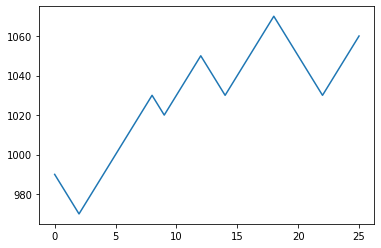

In [678]:
import matplotlib.pyplot as plt

list_db_price = [
    990, 980, 970, 980, 990, 1000, 1010, 1020, 1030, 1020, 1030, 1040, 1050, 1040, 1030, 1040, 1050, 1060, 1070, 1060, 1050, 1040, 1030, 1040, 1050, 1060
]

plt.plot(list_db_price)
plt.show()